## 2 Data

In [379]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import wrds
#db=wrds.Connection(wrds_username='sahakyan')

In [270]:
# #---------------------------------------------
# # Risk Free Rate 
# #---------------------------------------------
# Rf=db.raw_sql("""select  mcaldt,tmytm 
#            from crsp.tfz_mth_rf            
#             where kytreasnox = 2000001 
#            and mcaldt>='1964-01-01'
#             and mcaldt<='2023-12-31'""", date_cols=['mcaldt'])
# Rf['tmytm']=Rf['tmytm']/12/100
# Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})


# #---------------------------------------------
# # Value Weighted Index Returns
# #---------------------------------------------
# Rm=db.raw_sql("""select  date,vwretd from crsp.msi 
#                 where date>='1964-01-01' and date<='2023-12-31'
#                 """,date_cols=['date'])
# Rm = Rm.rename(columns={'vwretd':'Rm'})

# #---------------------------------------------
# # Stock Returns 
# #---------------------------------------------
# stock_data = db.raw_sql("""
#                     select a.permno, a.date, 
#                       b.shrcd, b.exchcd,
#                       a.ret, a.shrout, a.prc, b.siccd
#                       from crsp.msf as a
#                       left join crsp.msenames as b
#                       on a.permno=b.permno
#                       and b.namedt<=a.date
#                       and a.date<=b.nameendt
#                       where a.date between '01/01/1964' and '12/31/2023'
#                       and b.exchcd between 1 and 2
#                       and b.shrcd between 10 and 11
#                       """, date_cols=['date']) 
# stock_data=stock_data.drop(['shrcd','exchcd'],axis=1)
# stock_data = stock_data.rename(columns={'ret':'Rn'})
# stock_data['mcap'] = np.abs(stock_data['prc'])*stock_data['shrout']
# stock_data['mcap_l'] = stock_data.groupby(['permno'])['mcap'].shift(1)


# #---------------------------------------------
# # Merge Data 
# #---------------------------------------------
# data = pd.merge(stock_data, Rf, on=['date'], how='left')
# data = pd.merge(data, Rm, on=['date'], how='left')
# data['const'] = 1
# data['Rn_e'] = data['Rn']-data['rf']
# data['Rm_e'] = data['Rm']-data['rf']
# data.to_csv('data.csv', sep=';',index=False) # export data

## 3 Betting against Beta strategy (BaB)

#### (a) Computation of time-varying Beta

In [380]:
# load data
data = pd.read_csv('data.csv', sep=';')
data['date'] = pd.to_datetime(data['date'])
# get rid of the day in the date
data['date'] = data['date'].dt.to_period('M')
data['date'] = data['date'].dt.to_timestamp()

In [369]:
data = data.sort_values(by=['permno', 'date']).reset_index(drop=True)

In [370]:
# (a)
# 0. Remove nans
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

# 2. Estimate Rolling Betas
cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(window = 60, min_periods=36).cov()
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

# 3. Merge betas with data
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
data = data.merge(beta_n, on=['permno','date'], how='left')

# get rid of nan values
data = data.dropna(subset=['beta']).copy()

# 4. Remove outliers
data['beta'] = data['beta'].clip(data['beta'].quantile(0.05),data['beta'].quantile(0.95))

In [371]:
# save data with the beta
data.to_csv('data_with_beta_n.csv', sep=';',index=False)

#### (B) Beta Deciles

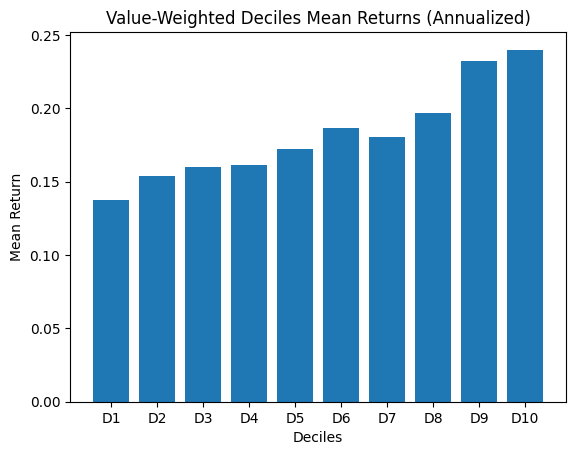

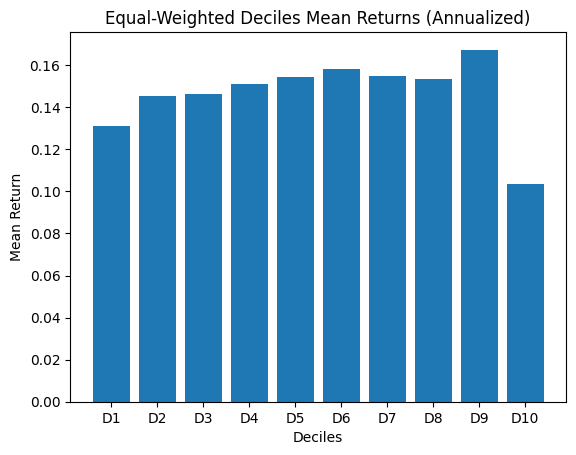

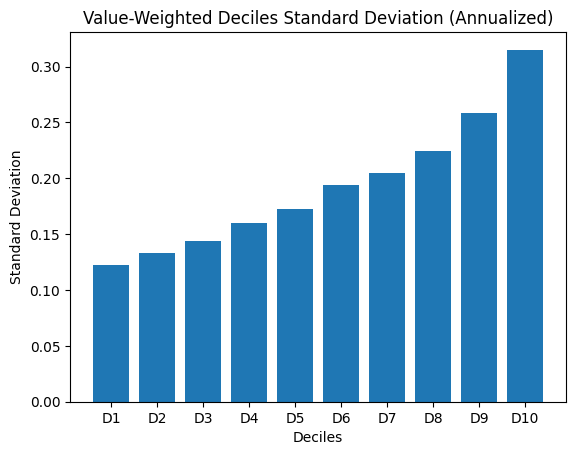

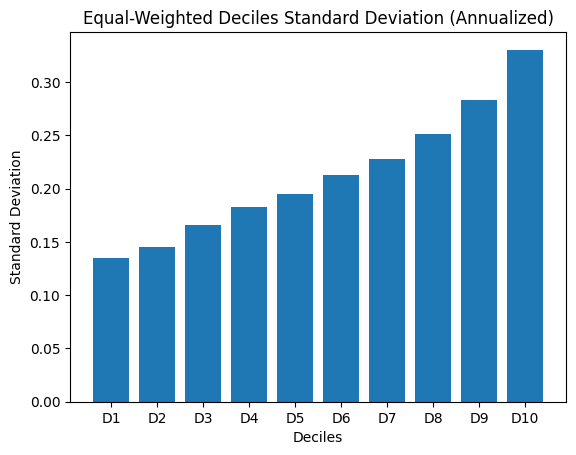

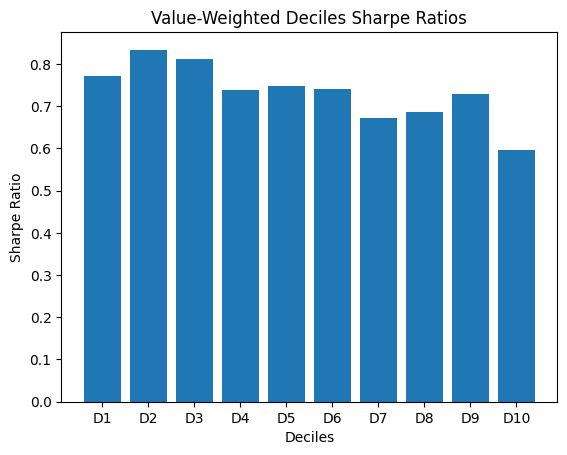

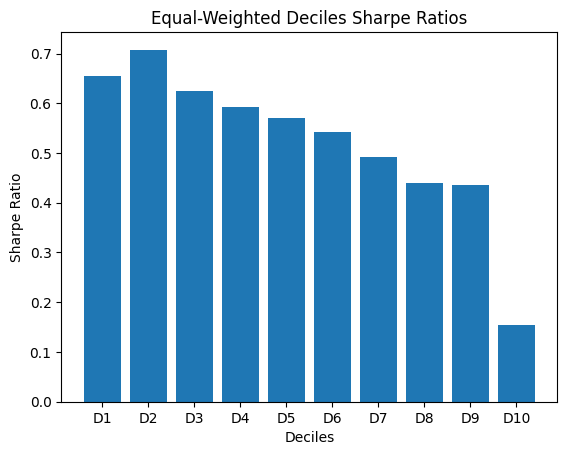

In [372]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# (b)
# 1. Deciles
data['beta_Q'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
# 2. Market Weights within deciles
data['vw_Q'] = data['mcap'] / data.groupby(['date', 'beta_Q'])['mcap'].transform('sum')

# 3. VW Portfolios
data['beta_ret_vw'] = data['vw_Q'] * data['Rn']
ret_vw = data.groupby(['date', 'beta_Q'])['beta_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_Q')['beta_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date', 'beta_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_Q')['Rn'].mean()

# Calculate standard deviations
vw_ret_std = ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
ew_ret_std = ret_ew.groupby('beta_Q')['Rn'].std()

# Compute the Sharpe Ratios for each decile

# compute the risk-free rate
rf = data.groupby(['date', 'beta_Q'])['rf'].mean().reset_index()

# compute the excess returns
ret_vw['excess'] = ret_vw['beta_ret_vw'] - rf['rf']
ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

# compute the Sharpe Ratios
vw_sharpe = ret_vw.groupby('beta_Q')['excess'].mean() / ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
ew_sharpe = ret_ew.groupby('beta_Q')['excess'].mean() / ret_ew.groupby('beta_Q')['Rn'].std()

# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

directory = 'Plots/Part3'

#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + '/vw_ret_mean.png')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + '/ew_ret_mean.png')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + '/vw_ret_std.png')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + '/ew_ret_std.png')
plt.show()

# Plot VW Sharpe Ratios
plt.bar(deciles, vw_sharpe* np.sqrt(12))
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + '/vw_sharpe.png')
plt.show()

# Plot EW Sharpe Ratios
plt.bar(deciles, ew_sharpe* np.sqrt(12))
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + '/ew_sharpe.png')
plt.show()

TODO
- Question: Summarize our findings. Is the evidence consistent with the CAPM?
- Answer:

#### (c/d) Construct BAB factor

In [373]:
# Weights
data['z'] = data.groupby('date')['beta'].transform(lambda x: x.rank())
data['z_'] = data['z']-data.groupby('date')['z'].transform('mean')
data['k'] = np.abs(data['z_'])
data['k'] = 2/data.groupby('date')['k'].transform('sum')
data['w_H'] = data['k'] * data['z_'] * (data['z_']>0) 
data['w_L'] = -data['k'] * data['z_'] * (data['z_']<0) 

# Weighted returns and beta
data['beta_H'] = data['w_H'] * data['beta']
data['beta_L'] = data['w_L'] * data['beta']
data['R_H'] = data['w_H'] * data['Rn']
data['R_L'] = data['w_L'] * data['Rn']
data['R_H_e'] = data['w_H'] * data['Rn_e']
data['R_L_e'] = data['w_L'] * data['Rn_e']

# Sum up the weighted returns and betas but not the rf
BAB = data.groupby('date')[['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()
BAB['rf'] = data.groupby('date')['rf'].mean().reset_index()['rf']
# unlevered returns
BAB['BAB2'] = (BAB['R_L_e']/BAB['beta_L']) - ( BAB['R_H_e']/BAB['beta_H'] )

In [374]:
# Merge Market and Risk free Rate
tmp = pd.merge(BAB,data[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['alpha'] = 1

# Alpha and Beta
import statsmodels.api as sm
tmp = tmp.dropna()
OLS_Reg = sm.OLS(tmp['BAB2'], tmp[['alpha','Rm_e']]).fit()

# Report the mean,standard deviation, and sharpe ratio and CAPM alpha of the BAB factor
print('Mean:', tmp['BAB2'].mean()*12)
print('Standard Deviation:', tmp['BAB2'].std()*np.sqrt(12))
# Annualize the Sharpe ratio and CAPM alpha
print('Sharpe ratio:', tmp['BAB2'].mean()/tmp['BAB2'].std()*np.sqrt(12))
print('Monthly CAPM Alpha:', OLS_Reg.params['alpha']*12)



Mean: 0.1187293114635383
Standard Deviation: 0.14074653526654435
Sharpe ratio: 0.8435682714227382
Monthly CAPM Alpha: 0.08334137801182329


Save factor for our investing strategy

In [375]:
strat = BAB[['date','rf','BAB2']].copy()
strat

,date,rf,BAB2
0,1967-01-01,0.003788,0.074142
1,1967-02-01,0.003737,0.017379
2,1967-03-01,0.003385,0.012749
3,1967-04-01,0.002877,0.022554
4,1967-05-01,0.002707,0.004873
...,...,...,...
677,2023-08-01,0.004463,-0.015452
678,2023-09-01,0.004472,-0.043764
679,2023-10-01,0.004475,0.005450
680,2023-11-01,0.004455,0.034858


## Part 4: Momentum Strategy (Mom)

In [376]:
# Load data
data = pd.read_csv('data.csv', delimiter=';')
#drop column mcap_l 
data = data.drop(columns=['mcap_l'])
#drop nan in Rn column
data = data.dropna(subset=['Rn'])
# Convert date to datetime
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.to_period('M')
data['date'] = data['date'].dt.to_timestamp()
# Sort the data by permno and date
data = data.sort_values(['permno', 'date']).reset_index(drop=True)
display(data.isna().sum())
data

permno       0
date         0
Rn           0
shrout       0
prc          0
siccd        0
mcap         0
rf        2076
Rm           0
const        0
Rn_e      2076
Rm_e      2076
dtype: int64

,permno,date,Rn,shrout,prc,siccd,mcap,rf,Rm,const,Rn_e,Rm_e
0,10001,2009-12-01,0.162621,4361.0,10.3000,4925,44918.3000,0.000032,0.028475,1,0.162589,0.028443
1,10001,2010-01-01,-0.018932,4361.0,10.0600,4925,43871.6600,0.000013,-0.037172,1,-0.018945,-0.037185
2,10001,2010-02-01,-0.000656,4361.0,10.0084,4925,43646.6324,0.000061,0.034744,1,-0.000717,0.034683
3,10001,2010-03-01,0.020643,4361.0,10.1700,4925,44351.3700,0.000112,0.063668,1,0.020531,0.063556
4,10001,2010-04-01,0.124385,6070.0,11.3900,4925,69137.3000,0.000118,0.020036,1,0.124267,0.019918
...,...,...,...,...,...,...,...,...,...,...,...,...
1432773,93426,2023-08-01,-0.037156,12581.0,36.0200,3676,453167.6200,0.004463,-0.020605,1,-0.041619,-0.025068
1432774,93426,2023-09-01,-0.067740,12581.0,33.5800,3676,422469.9800,0.004472,-0.047390,1,-0.072212,-0.051862
1432775,93426,2023-10-01,-0.108993,12581.0,29.9200,3676,376423.5200,0.004475,-0.028867,1,-0.113468,-0.033342
1432776,93426,2023-11-01,0.019051,12510.0,30.4900,3676,381429.9000,0.004455,0.092057,1,0.014596,0.087602


In [377]:
data['LN_Cret12'] = data.groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11, min_periods = 11, closed='left').sum()).values

# shift the LN_Cret12 column by 1
data['LN_Cret12'] = data.groupby('permno')['LN_Cret12'].shift(1)
data.dropna(subset=['LN_Cret12'], inplace=True)

q = 10
data['Momentum'] = data.groupby('date')['LN_Cret12'].transform(lambda x: pd.qcut(x,q,labels=False, duplicates='drop'))
data

C:\Users\edoul\AppData\Local\Temp\ipykernel_28612\671579043.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['LN_Cret12'] = data.groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11, min_periods = 11, closed='left').sum()).values


,permno,date,Rn,shrout,prc,siccd,mcap,rf,Rm,const,Rn_e,Rm_e,LN_Cret12,Momentum
12,10001,2010-12-01,0.052291,7834.0,10.52,4925,82413.68,0.000068,0.067182,1,0.052223,0.067114,0.297149,7
13,10001,2011-01-01,0.028992,7834.0,10.78,4925,84450.52,0.000125,0.019183,1,0.028867,0.019058,0.020414,3
14,10001,2011-02-01,0.022727,7834.0,10.98,4925,86017.32,0.000065,0.038156,1,0.022662,0.038091,0.090498,2
15,10001,2011-03-01,0.072404,7834.0,11.73,4925,91892.82,0.000049,0.003341,1,0.072355,0.003292,0.119734,3
16,10001,2011-04-01,-0.038789,8151.0,11.23,4925,91535.73,0.000013,0.028597,1,-0.038802,0.028584,0.121773,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432773,93426,2023-08-01,-0.037156,12581.0,36.02,3676,453167.62,0.004463,-0.020605,1,-0.041619,-0.025068,0.175187,7
1432774,93426,2023-09-01,-0.067740,12581.0,33.58,3676,422469.98,0.004472,-0.047390,1,-0.072212,-0.051862,0.086501,5
1432775,93426,2023-10-01,-0.108993,12581.0,29.92,3676,376423.52,0.004475,-0.028867,1,-0.113468,-0.033342,0.196638,5
1432776,93426,2023-11-01,0.019051,12510.0,30.49,3676,381429.90,0.004455,0.092057,1,0.014596,0.087602,-0.005050,5


In [359]:
# 2. Market Weights within deciles
data['vw_Q'] = data['mcap']/data.groupby(['date','Momentum'])['mcap'].transform('sum')

# 3. VW Portfolios
data['MOM_ret_vw'] = data['vw_Q']*data['Rn']
ret_vw = data.groupby(['date','Momentum'])['MOM_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('Momentum')['MOM_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date','Momentum'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('Momentum')['Rn'].mean()

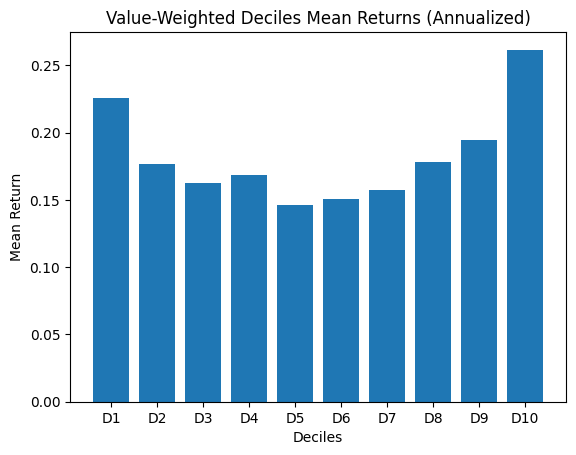

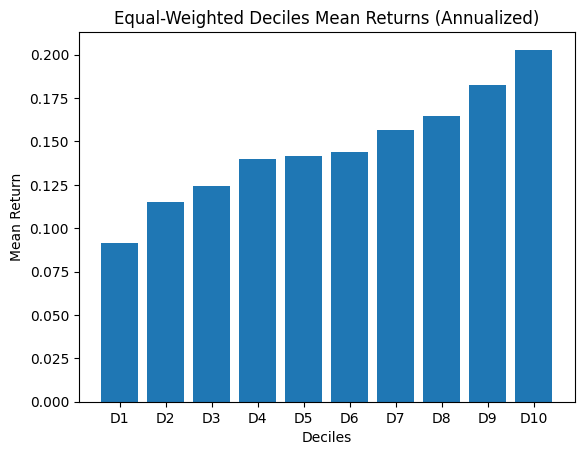

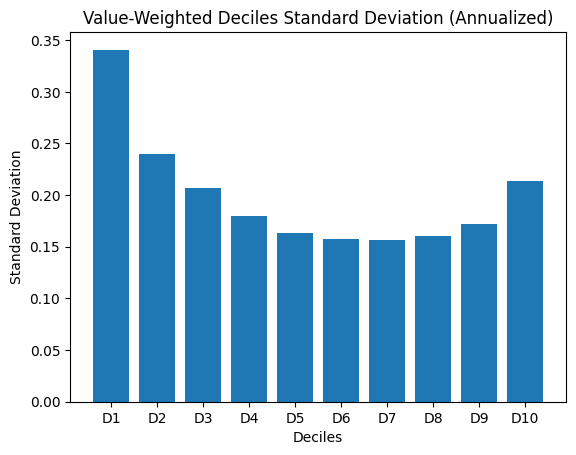

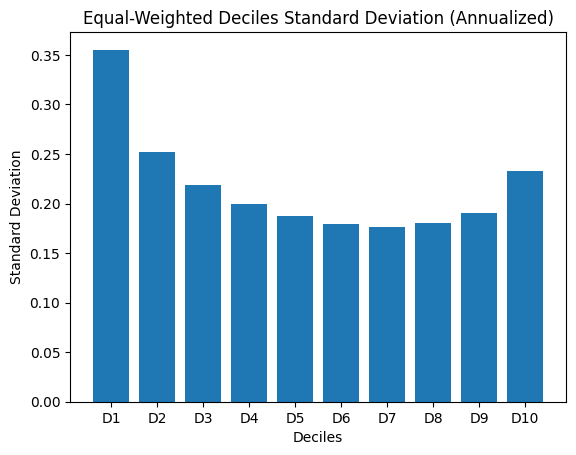

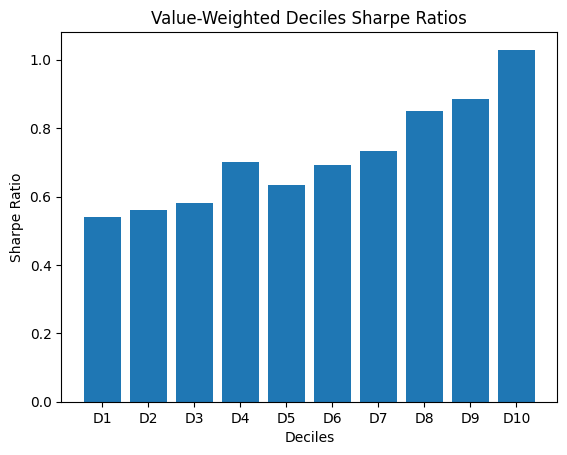

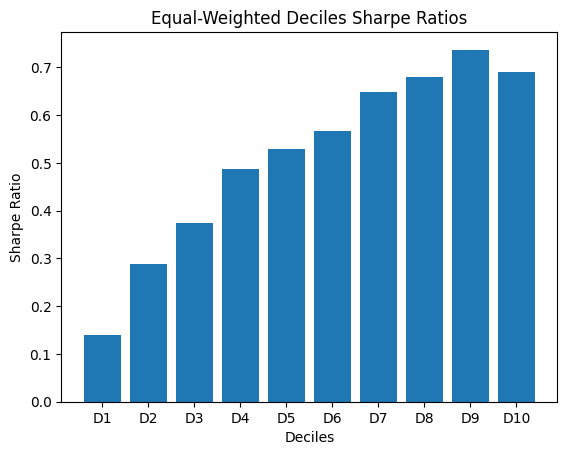

In [360]:
# Calculate standard deviations
vw_ret_std = ret_vw.groupby('Momentum')['MOM_ret_vw'].std()
ew_ret_std = ret_ew.groupby('Momentum')['Rn'].std()

# Calculate Sharpe Ratios

# compute the risk-free rate
rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

# compute the excess returns
ret_vw['excess'] = ret_vw['MOM_ret_vw'] - rf['rf']
ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

# compute the Sharpe Ratios
vw_sharpe_ratio = ret_vw.groupby('Momentum')['excess'].mean() / vw_ret_std
ew_sharpe_ratio = ret_ew.groupby('Momentum')['excess'].mean() / ew_ret_std


# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

directory = 'Plots/Part4/'
#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + 'vw_ret_mean.png')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + 'ew_ret_mean.png')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + 'vw_ret_std.png')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + 'ew_ret_std.png')
plt.show()

# Plot VW Sharpe ratios
plt.bar(deciles, vw_sharpe_ratio * np.sqrt(12))
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + 'vw_sharpe_ratio.png')
plt.show()

# Plot EW Sharpe ratios
plt.bar(deciles, ew_sharpe_ratio * np.sqrt(12))
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + 'ew_sharpe_ratio.png')
plt.show()

### Factor creation

#### Equal-Weighted Long-Short Factor Strategy

In [361]:
# 1. Compute the long and short legs of the strategy
ew_long_leg = data[data['Momentum'] >= 7].groupby('date')['Rn'].mean().reset_index()
ew_short_leg = data[data['Momentum'] < 3].groupby('date')['Rn'].mean().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

ew_long_leg['excess'] = ew_long_leg['Rn'] - rf['rf']
ew_short_leg['excess'] = ew_short_leg['Rn'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = ew_long_leg['Rn'].mean() * 12
short_mean = ew_short_leg['Rn'].mean() * 12

long_mean_e = ew_long_leg['excess'].mean() * 12
short_mean_e = ew_short_leg['excess'].mean() * 12

long_std = ew_long_leg['Rn'].std() * np.sqrt(12)
short_std = ew_short_leg['Rn'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = ew_long_leg.set_index("date") - ew_short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['Rn'] - rf['rf']

factor_mean = factor['Rn'].mean() * 12
factor_mean_e = factor['excess'].mean() * 12
factor_std = factor['Rn'].std() * np.sqrt(12)
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 0.18349772813987653
Short Leg Mean Return: 0.11027267804475926
Long Leg Standard Deviation: 0.1975442842556307
Short Leg Standard Deviation: 0.26801944208572653
Long Leg Sharpe Ratio: 0.6729430761519648
Short Leg Sharpe Ratio: 0.2306584526124965
Factor Mean Return: 0.07322505009511728
Factor Standard Deviation: 0.1675909026499953
Factor Sharpe Ratio: 0.12688503321712993


In [362]:
import scipy.stats as stats

# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')


T-Statistic: 11.625880810436598
P-Value: 0.0
The factor strategy has an average return that is statistically significantly different from zero.


#### Value-Weighted Long-Short Factor Strategy

In [363]:
#1. Compute the long and short legs of the strategy
vw_long_leg = data[data['Momentum'] >= 7].groupby('date')['MOM_ret_vw'].sum().reset_index()
vw_short_leg = data[data['Momentum'] < 3].groupby('date')['MOM_ret_vw'].sum().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

vw_long_leg['excess'] = vw_long_leg['MOM_ret_vw'] - rf['rf']
vw_short_leg['excess'] = vw_short_leg['MOM_ret_vw'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = vw_long_leg['MOM_ret_vw'].mean() * 12
short_mean = vw_short_leg['MOM_ret_vw'].mean() * 12

long_mean_e = vw_long_leg['excess'].mean() * 12
short_mean_e = vw_short_leg['excess'].mean() * 12

long_std = vw_long_leg['MOM_ret_vw'].std() * np.sqrt(12)
short_std = vw_short_leg['MOM_ret_vw'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = vw_long_leg.set_index("date") - vw_short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['MOM_ret_vw'] - rf['rf']

factor_mean = factor['MOM_ret_vw'].mean() * 12
factor_mean_e = factor['excess'].mean() * 12
factor_std = factor['MOM_ret_vw'].std() * np.sqrt(12)
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 0.6340076953377646
Short Leg Mean Return: 0.5653608046375727
Long Leg Standard Deviation: 0.5203218892594201
Short Leg Standard Deviation: 0.7494202595343373
Long Leg Sharpe Ratio: 1.1237936105157909
Short Leg Sharpe Ratio: 0.6791625155060891
Factor Mean Return: 0.06864689070019186
Factor Standard Deviation: 0.6036595189051945
Factor Sharpe Ratio: 0.04291481177937426


In [364]:
# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')

T-Statistic: 3.025836425040632
P-Value: 0.0012397319966197529
The factor strategy has an average return that is statistically significantly different from zero.


In [365]:
# Save Mom return in strat dataframe
strat = strat.merge(factor[['date','MOM_ret_vw']], on='date', how='left')

In [366]:
strat

,date,rf,BAB2,MOM_ret_vw
0,1967-01-01,0.003788,0.074142,-0.244450
1,1967-02-01,0.003737,0.017379,0.076805
2,1967-03-01,0.003385,0.012749,0.049046
3,1967-04-01,0.002877,0.022554,-0.017797
4,1967-05-01,0.002707,0.004873,0.053441
...,...,...,...,...
677,2023-08-01,0.004463,-0.015452,0.172734
678,2023-09-01,0.004472,-0.043764,0.018452
679,2023-10-01,0.004475,0.005450,-0.026999
680,2023-11-01,0.004455,0.034858,0.051445


# Part 5: Idiosyncratic Volatility Strategy (IV)

In [234]:
data = pd.read_csv("data.csv",sep=";")
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.to_period('M')
data['date'] = data['date'].dt.to_timestamp()
# sort the data by date inside each permno
data = data.sort_values(by=['permno','date']).reset_index(drop=True)

In [235]:
# 0. Remove nans
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

# 2. Estimate Rolling Betas
cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(60, min_periods=36).cov()
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

# 3. Merge With data
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
data = pd.merge(data, beta_n, on=['date','permno'], how='left')

# get rid of nan values
data = data.dropna(subset=['beta']).copy()

# 4. Remove outliers
data['beta'] = data['beta'].clip(data['beta'].quantile(0.05),data['beta'].quantile(0.95))

In [236]:
data

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,beta
36,10001,2013-01-01,0.062701,8157.0,9.87,80509.59,81080.58,0.000051,0.054142,1,0.062650,0.054091,0.464682
37,10001,2013-02-01,0.011651,8157.0,9.94,81080.58,83201.40,0.000040,0.008282,1,0.011611,0.008242,0.484416
38,10001,2013-03-01,0.030684,8157.0,10.20,83201.40,86668.70,0.000034,0.035295,1,0.030650,0.035261,0.484182
39,10001,2013-04-01,0.017157,8390.0,10.33,86668.70,86249.20,0.000013,0.014939,1,0.017144,0.014926,0.487155
40,10001,2013-05-01,-0.000484,8390.0,10.28,86249.20,89064.10,0.000013,0.019128,1,-0.000497,0.019115,0.487298
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420788,93426,2023-08-01,-0.037156,12581.0,36.02,453167.62,422469.98,0.004463,-0.020605,1,-0.041619,-0.025068,1.312988
1420789,93426,2023-09-01,-0.067740,12581.0,33.58,422469.98,376423.52,0.004472,-0.047390,1,-0.072212,-0.051862,1.306562
1420790,93426,2023-10-01,-0.108993,12581.0,29.92,376423.52,381429.90,0.004475,-0.028867,1,-0.113468,-0.033342,1.299385
1420791,93426,2023-11-01,0.019051,12510.0,30.49,381429.90,426215.70,0.004455,0.092057,1,0.014596,0.087602,1.300548


In [237]:
# 5. Calculate IV:
# Calculate the predicted return
data['predicted_return_e'] = data['beta'] * data['Rm_e']

# Calculate the residuals
data['residuals'] = data['Rn_e'] - data['predicted_return_e']

# Calculate the rolling standard deviation of the residuals
idiosyncratic_volatility = data.set_index('date').groupby('permno')['residuals'].rolling(window=60, min_periods=36).std()

# Reset the index of the idiosyncratic_volatility Series
idiosyncratic_volatility = idiosyncratic_volatility.reset_index()

# Rename the 0 column to 'idiosyncratic_volatility'
idiosyncratic_volatility = idiosyncratic_volatility.rename(columns={"residuals": 'idiosyncratic_volatility'})

# Merge the idiosyncratic_volatility DataFrame with the original data DataFrame
data = pd.merge(data, idiosyncratic_volatility, on=['date', 'permno'], how='left')

# Drop the intermediate columns
data = data.drop(columns=['predicted_return_e', 'residuals'])

# Drop nans in the idiosyncratic_volatility and beta columns
data = data.dropna(subset=['idiosyncratic_volatility'])

# 4. Remove outliers
data['idiosyncratic_volatility'] = data['idiosyncratic_volatility'].clip(data['idiosyncratic_volatility'].quantile(0.05),data['idiosyncratic_volatility'].quantile(0.95))

In [238]:
data

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,beta,idiosyncratic_volatility
35,10001,2015-12-01,-0.132151,10505.0,7.45,78262.25,87401.60,0.000057,-0.022209,1,-0.132208,-0.022266,0.257580,0.073474
36,10001,2016-01-01,0.116779,10505.0,8.32,87401.60,82569.30,0.000190,-0.057085,1,0.116589,-0.057275,0.257580,0.075759
37,10001,2016-02-01,-0.055288,10505.0,7.86,82569.30,82067.48,0.000186,0.000620,1,-0.055474,0.000434,0.257580,0.075274
38,10001,2016-03-01,-0.006361,10508.0,7.81,82067.48,76737.60,0.000063,0.070491,1,-0.006424,0.070428,0.257580,0.074371
39,10001,2016-04-01,-0.055698,10512.0,7.30,76737.60,75055.68,0.000110,0.011718,1,-0.055808,0.011608,0.257580,0.073961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118622,93426,2023-08-01,-0.037156,12581.0,36.02,453167.62,422469.98,0.004463,-0.020605,1,-0.041619,-0.025068,1.312988,0.064385
1118623,93426,2023-09-01,-0.067740,12581.0,33.58,422469.98,376423.52,0.004472,-0.047390,1,-0.072212,-0.051862,1.306562,0.062242
1118624,93426,2023-10-01,-0.108993,12581.0,29.92,376423.52,381429.90,0.004475,-0.028867,1,-0.113468,-0.033342,1.299385,0.062429
1118625,93426,2023-11-01,0.019051,12510.0,30.49,381429.90,426215.70,0.004455,0.092057,1,0.014596,0.087602,1.300548,0.063323


## Sorting

In [239]:
data['IV_Q'] = data.groupby('date')['idiosyncratic_volatility'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

# 2. Market Weights within deciles
data['vw_Q'] = data['mcap']/data.groupby(['date','IV_Q'])['mcap'].transform('sum')

# 3. VW Portfolios
data['IV_ret_vw'] = data['vw_Q']*data['Rn']
ret_vw = data.groupby(['date','IV_Q'])['IV_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('IV_Q')['IV_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date','IV_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('IV_Q')['Rn'].mean()

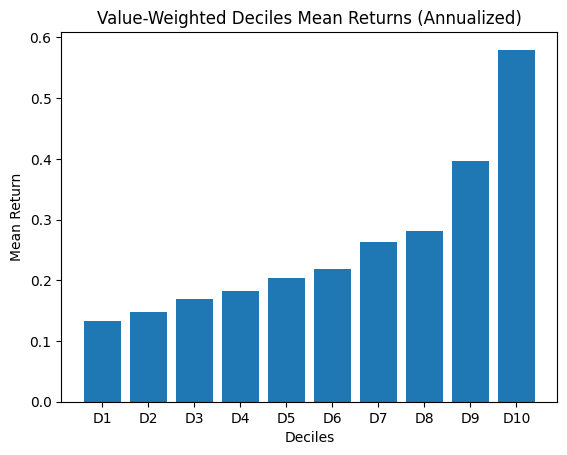

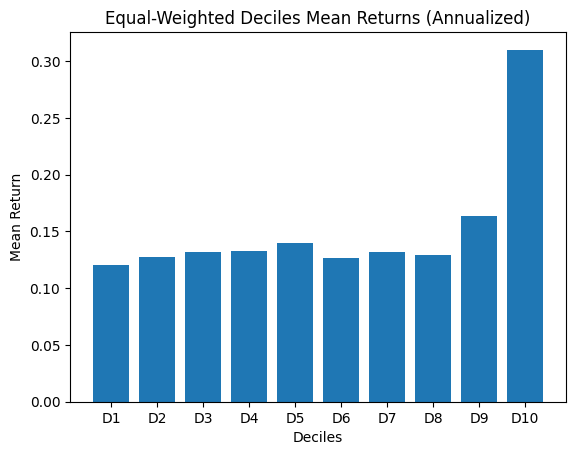

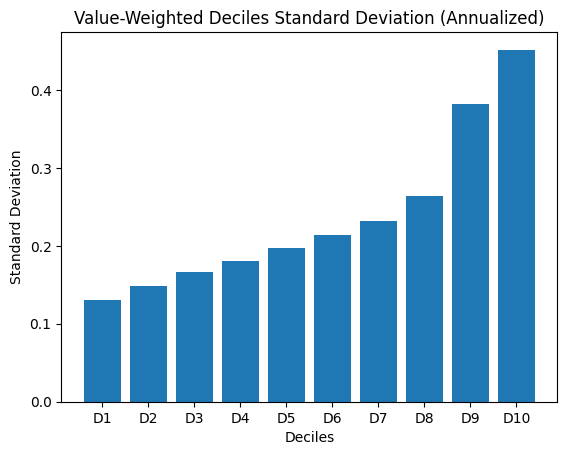

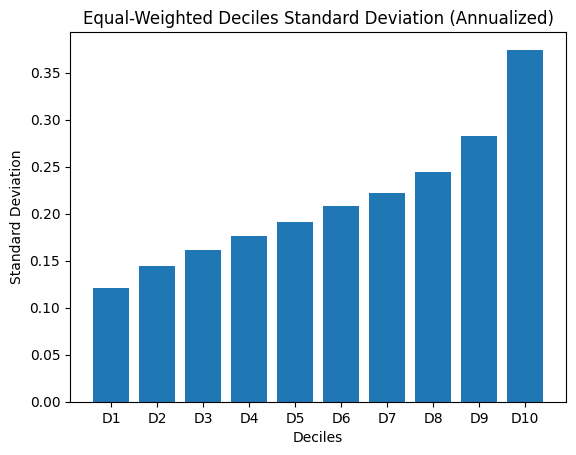

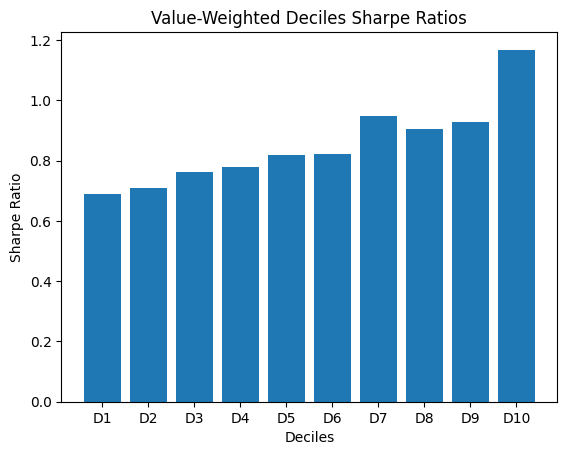

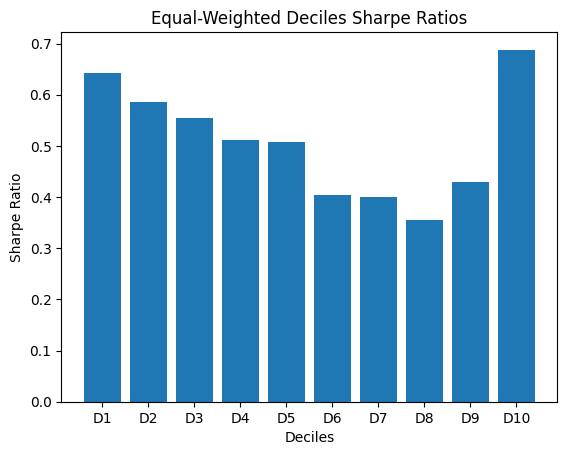

In [240]:
# Calculate standard deviations
vw_ret_std = ret_vw.groupby('IV_Q')['IV_ret_vw'].std()
ew_ret_std = ret_ew.groupby('IV_Q')['Rn'].std()

# Calculate Sharpe Ratios

# compute the risk-free rate
rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

# compute the excess returns
ret_vw['excess'] = ret_vw['IV_ret_vw'] - rf['rf']
ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

# compute the Sharpe Ratios
vw_sharpe_ratio = ret_vw.groupby('IV_Q')['excess'].mean() / vw_ret_std
ew_sharpe_ratio = ret_ew.groupby('IV_Q')['excess'].mean() / ew_ret_std


# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

directory = 'Plots/Part5/'
#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + 'vw_ret_mean.png')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + 'ew_ret_mean.png')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + 'vw_ret_std.png')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + 'ew_ret_std.png')
plt.show()

# Plot VW Sharpe ratios
plt.bar(deciles, vw_sharpe_ratio * np.sqrt(12))
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + 'vw_sharpe_ratio.png')
plt.show()

# Plot EW Sharpe ratios
plt.bar(deciles, ew_sharpe_ratio * np.sqrt(12))
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + 'ew_sharpe_ratio.png')
plt.show()

### Factor creation

Equally weighted factor strategy

In [241]:
# 1. Compute the long and short legs of the strategy
long_leg = data[data['IV_Q'] >= 7].groupby('date')['Rn'].mean().reset_index()
short_leg = data[data['IV_Q'] < 3].groupby('date')['Rn'].mean().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

long_leg['excess'] = long_leg['Rn'] - rf['rf']
short_leg['excess'] = short_leg['Rn'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = long_leg['Rn'].mean() * 12
short_mean = short_leg['Rn'].mean() *12

long_mean_e = long_leg['excess'].mean() *12
short_mean_e = short_leg['excess'].mean() * 12

long_std = long_leg['Rn'].std() * np.sqrt(12)
short_std = short_leg['Rn'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = long_leg.set_index("date") - short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['Rn'] - rf['rf']

factor_mean = factor['Rn'].mean() * 12
factor_mean_e = factor['excess'].mean() * 12
factor_std = factor['Rn'].std() * np.sqrt(12)
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 0.18635729930298928
Short Leg Mean Return: 0.12690889533316246
Long Leg Standard Deviation: 0.2844165281220083
Short Leg Standard Deviation: 0.13854701691032753
Long Leg Sharpe Ratio: 0.4582068032083559
Short Leg Sharpe Ratio: 0.5115460855173061
Factor Mean Return: 0.05944840396982683
Factor Standard Deviation: 0.20240206616999057
Factor Sharpe Ratio: 0.016860958298598627


In [242]:
import scipy.stats as stats

# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')


T-Statistic: 7.470976979834049
P-Value: 3.9745984281580604e-14
The factor strategy has an average return that is statistically significantly different from zero.


Value weighted factor strategy

In [243]:
#1. Compute the long and short legs of the strategy
vw_long_leg = data[data['IV_Q'] >= 7].groupby('date')['IV_ret_vw'].sum().reset_index()
vw_short_leg = data[data['IV_Q'] < 3].groupby('date')['IV_ret_vw'].sum().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

vw_long_leg['excess'] = vw_long_leg['IV_ret_vw'] - rf['rf']
vw_short_leg['excess'] = vw_short_leg['IV_ret_vw'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = vw_long_leg['IV_ret_vw'].mean() * 12
short_mean = vw_short_leg['IV_ret_vw'].mean() * 12

long_mean_e = vw_long_leg['excess'].mean() * 12
short_mean_e = vw_short_leg['excess'].mean() * 12

long_std = vw_long_leg['IV_ret_vw'].std() * np.sqrt(12)
short_std = vw_short_leg['IV_ret_vw'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = vw_long_leg.set_index("date") - vw_short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['IV_ret_vw'] - rf['rf']

factor_mean = factor['IV_ret_vw'].mean()
factor_mean_e = factor['excess'].mean()
factor_std = factor['IV_ret_vw'].std()
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 1.118689308599013
Short Leg Mean Return: 0.45037701131969143
Long Leg Standard Deviation: 0.9026877753737894
Short Leg Standard Deviation: 0.4332082054626096
Long Leg Sharpe Ratio: 1.1772105775847024
Short Leg Sharpe Ratio: 0.9102812346917626
Factor Mean Return: 0.05569269143994347
Factor Standard Deviation: 0.2055641015197879
Factor Sharpe Ratio: 0.2482099182931342


In [244]:
# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')

T-Statistic: 6.891330399940502
P-Value: 2.763678175199402e-12
The factor strategy has an average return that is statistically significantly different from zero.


Save factor for our investing strategy

In [378]:
# Merge factor dataframe with strat dataframe

strat = strat.merge(factor[['date','IV_ret_vw']], on='date', how='left')

# Drop all nans
strat = strat.dropna()

KeyError: "['IV_ret_vw'] not in index"

In [246]:
# rename columns to IV and MOM
strat = strat.rename(columns={'IV_ret_vw':'IV','MOM_ret_vw':'MOM'})
strat

,date,rf,BAB2,MOM,IV
35,1970-02-01,0.005253,0.028447,0.045441,0.004046
36,1970-03-01,0.005345,0.027152,0.070217,-0.105443
37,1970-04-01,0.005427,-0.040348,0.174635,-0.412375
38,1970-05-01,0.005257,-0.052342,0.005201,-0.126094
39,1970-06-01,0.004942,0.007017,0.201597,-0.100487
...,...,...,...,...,...
677,2023-08-01,0.004463,-0.015483,0.172734,0.027415
678,2023-09-01,0.004472,-0.043784,0.018452,0.028765
679,2023-10-01,0.004475,0.005453,-0.026999,-0.064254
680,2023-11-01,0.004455,0.034961,0.051445,-0.054077


In [247]:
strat.to_csv('strat.csv', sep=';',index=False) # export data

In [248]:
# read csv
strat = pd.read_csv('strat.csv', sep=';')

## 6 Optimal Fund Portfolio Return (STRAT)

In [309]:
# Equal weight strategy
strat['STRAT1'] = (strat['BAB2'] + strat['IV'] + strat['MOM'])/3

# Window size equal to data length
number_of_rows = len(strat)


# Risk-Parity strategy
rolling_vol = strat[['BAB2', 'IV', 'MOM']].rolling(window = 60,min_periods=36).std()
weights = 1 / rolling_vol
# Normalize the weights
weights = weights.div(weights.sum(axis=1), axis=0)
strat['STRAT2'] = (weights['BAB2'] * strat['BAB2'] + weights['IV'] * strat['IV'] + weights['MOM'] * strat['MOM'])
strat["STRAT2_W_BAB"] = weights['BAB2']
strat["STRAT2_W_IV"] = weights['IV']
strat["STRAT2_W_MOM"] = weights['MOM']

# Mean-variance optimal combination
rolling_mean = strat[['BAB2', 'IV', 'MOM']].rolling(window = 60, min_periods=36).mean()
rolling_cov = strat[['BAB2', 'IV', 'MOM']].rolling(window = 60, min_periods=36).cov()

# Optimal weights = 1/a * Cov^(-1) * (mu - lambda * 1). Where lambda = (B - a) / A

# Define the risk aversion
a = 1

# Iterate over the rolling windows
optimal_weights = []
for i in range(number_of_rows):
    mu = rolling_mean.iloc[i].values
    cov = rolling_cov.loc[rolling_cov.index.get_level_values(0) == i].droplevel(0)
    ones = np.ones(len(mu))
    A = ones.T @ np.linalg.inv(cov) @ ones
    B = ones.T @ np.linalg.inv(cov) @ mu
    lambda_ = (B - a) / A
    optimal_weight = 1 / a * np.linalg.inv(cov) @ (mu - lambda_ * ones)
    optimal_weights.append(optimal_weight)

optimal_weights = pd.DataFrame(optimal_weights, columns = ['BAB2', 'IV', 'MOM'])
strat['STRAT3'] = (optimal_weights['BAB2'] * strat['BAB2'] + optimal_weights['IV'] * strat['IV'] + optimal_weights['MOM'] * strat['MOM'])

In [317]:
strat
#save startegy data
strat.to_csv('strat.csv', sep=';',index=False) # export data

In [310]:
# std
# Iv = 0.2
# Mom = 0.6
# Bab = 0.14

# sharp ratio
# Iv = 0.24
# Mom = 0.05
# Bab = 0.84
optimal_weights

,BAB2,IV,MOM
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
642,0.161883,0.916725,-0.078608
643,0.129023,0.934152,-0.063175
644,0.105495,0.941060,-0.046554
645,0.064149,0.971602,-0.035750


In [251]:
# Remove the first 3 lines from strat
#strat = strat.iloc[3:]
strat

,date,rf,BAB2,MOM,IV,STRAT1,STRAT2,STRAT3
0,1970-02-01,0.005253,0.028447,0.045441,0.004046,0.025978,NaN,NaN
1,1970-03-01,0.005345,0.027152,0.070217,-0.105443,-0.002691,NaN,NaN
2,1970-04-01,0.005427,-0.040348,0.174635,-0.412375,-0.092696,NaN,NaN
3,1970-05-01,0.005257,-0.052342,0.005201,-0.126094,-0.057745,NaN,NaN
4,1970-06-01,0.004942,0.007017,0.201597,-0.100487,0.036042,NaN,NaN
...,...,...,...,...,...,...,...,...
642,2023-08-01,0.004463,-0.015483,0.172734,0.027415,0.061555,0.013423,0.009047
643,2023-09-01,0.004472,-0.043784,0.018452,0.028765,0.001144,-0.028718,0.020056
644,2023-10-01,0.004475,0.005453,-0.026999,-0.064254,-0.028600,-0.005306,-0.058635
645,2023-11-01,0.004455,0.034961,0.051445,-0.054077,0.010776,0.028844,-0.052138


In [252]:
# Calculate the annualized volatility and mean of the STRAT1, STRAT2, and STRAT3 strategies
strat1_mean = strat['STRAT1'].mean() * 12
strat1_std = strat['STRAT1'].std() * np.sqrt(12)
excess_strat1 = strat['STRAT1'] - strat['rf']
strat1_sharpe = excess_strat1.mean() / strat["STRAT1"].std() * np.sqrt(12)

strat2_mean = strat['STRAT2'].mean() * 12
strat2_std = strat['STRAT2'].std() * np.sqrt(12)
excess_strat2 = strat['STRAT2'] - strat['rf']
strat2_sharpe = excess_strat2.mean() / strat["STRAT2"].std() * np.sqrt(12)

strat3_mean = strat['STRAT3'].mean() * 12
strat3_std = strat['STRAT3'].std() * np.sqrt(12)
excess_strat3 = strat['STRAT3'] - strat['rf']
strat3_sharpe = excess_strat3.mean() / strat["STRAT3"].std() * np.sqrt(12)

# Print the results
print('Equal Weighted Strategy:')
print('Mean:', strat1_mean)
print('Standard Deviation:', strat1_std)
print('Sharpe Ratio:', strat1_sharpe)
print("\n")

print('Risk-Parity Strategy:')
print('Mean:', strat2_mean)
print('Standard Deviation:', strat2_std)
print('Sharpe Ratio:', strat2_sharpe)
print("\n")

print('Mean-Variance Optimal Strategy:')
print('Mean:', strat3_mean)
print('Standard Deviation:', strat3_std)
print('Sharpe Ratio:', strat3_sharpe)

Equal Weighted Strategy:
Mean: 0.27010550831770663
Standard Deviation: 0.2626137808430498
Sharpe Ratio: 0.8666406743701063


Risk-Parity Strategy:
Mean: 0.18552322991476522
Standard Deviation: 0.1549999086702273
Sharpe Ratio: 0.9236645620597163


Mean-Variance Optimal Strategy:
Mean: 1.4657023664148179
Standard Deviation: 1.2289653315480267
Sharpe Ratio: 1.158166974058056


In [253]:
# Now find c such that the average annual volatility of the fund is 10% in each case
c1 = 0.1 / strat1_std
c2 = 0.1 / strat2_std
c3 = 0.1 / strat3_std

# Calculate the fund returns
strat['fund1'] = strat['rf'] + c1 * strat['STRAT1']
strat['fund2'] = strat['rf'] + c2 * strat['STRAT2']
strat['fund3'] = strat['rf'] + c3 * strat['STRAT3']

# Calculate the annualized volatility and mean of the fund returns
fund1_mean = strat['fund1'].mean() * 12
fund1_std = strat['fund1'].std() * np.sqrt(12)
excess_fund1 = strat['fund1'] - strat['rf']
fund1_sharpe = excess_fund1.mean() / strat["fund1"].std() * np.sqrt(12)

fund2_mean = strat['fund2'].mean() * 12
fund2_std = strat['fund2'].std() * np.sqrt(12)
excess_fund2 = strat['fund2'] - strat['rf']
fund2_sharpe = excess_fund2.mean() / strat["fund2"].std() * np.sqrt(12)

fund3_mean = strat['fund3'].mean() * 12
fund3_std = strat['fund3'].std() * np.sqrt(12)
excess_fund3 = strat['fund3'] - strat['rf']
fund3_sharpe = excess_fund3.mean() / strat["fund3"].std() * np.sqrt(12)

# Print the results

# Print the c
print('c1:', c1)
print('c2:', c2)
print('c3:', c3)
print("\n")

print('Equal Weighted Fund:')
print('Mean:', fund1_mean)
print('Standard Deviation:', fund1_std)
print('Sharpe Ratio:', fund1_sharpe)
print("\n")

print('Risk-Parity Fund:')
print('Mean:', fund2_mean)
print('Standard Deviation:', fund2_std)
print('Sharpe Ratio:', fund2_sharpe)
print("\n")

print('Mean-Variance Optimal Fund:')
print('Mean:', fund3_mean)
print('Standard Deviation:', fund3_std)
print('Sharpe Ratio:', fund3_sharpe)


c1: 0.3807873283685925
c2: 0.6451616704675401
c3: 0.081369260330589


Equal Weighted Fund:
Mean: 0.14536647907894268
Standard Deviation: 0.10064041142250997
Sharpe Ratio: 1.0219826552391789


Risk-Parity Fund:
Mean: 0.16204778407592713
Standard Deviation: 0.10049883901843065
Sharpe Ratio: 1.190983677934755


Mean-Variance Optimal Fund:
Mean: 0.16161842457355133
Standard Deviation: 0.10117248896245398
Sharpe Ratio: 1.1788097598767908


In [254]:
# export strat
strat.to_csv('strat.csv', sep=';',index=False) # export data
strat

,date,rf,BAB2,MOM,IV,STRAT1,STRAT2,STRAT3,fund1,fund2,fund3
0,1970-02-01,0.005253,0.028447,0.045441,0.004046,0.025978,NaN,NaN,0.015145,NaN,NaN
1,1970-03-01,0.005345,0.027152,0.070217,-0.105443,-0.002691,NaN,NaN,0.004321,NaN,NaN
2,1970-04-01,0.005427,-0.040348,0.174635,-0.412375,-0.092696,NaN,NaN,-0.029871,NaN,NaN
3,1970-05-01,0.005257,-0.052342,0.005201,-0.126094,-0.057745,NaN,NaN,-0.016732,NaN,NaN
4,1970-06-01,0.004942,0.007017,0.201597,-0.100487,0.036042,NaN,NaN,0.018667,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
642,2023-08-01,0.004463,-0.015483,0.172734,0.027415,0.061555,0.013423,0.009047,0.027903,0.013123,0.005200
643,2023-09-01,0.004472,-0.043784,0.018452,0.028765,0.001144,-0.028718,0.020056,0.004907,-0.014056,0.006104
644,2023-10-01,0.004475,0.005453,-0.026999,-0.064254,-0.028600,-0.005306,-0.058635,-0.006415,0.001052,-0.000296
645,2023-11-01,0.004455,0.034961,0.051445,-0.054077,0.010776,0.028844,-0.052138,0.008558,0.023064,0.000213


## 7 Performance and risk analysis for the Fund strategy

We keep the risk parity approach
### a)

##### Data processing

- Industries

In [255]:
industries =['NoDur',
 'Durbl',
 'Manuf',
 'Enrgy',
 'Chems',
 'BusEq',
 'Telcm',
 'Utils',
 'Shops',
 'Hlth',
 'Money',
 'Other']

In [256]:
from io import StringIO

# Function to skip problematic rows and clean the data
def skip_and_clean_rows(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Keep lines that start with numeric values or are part of the header, and strip leading/trailing whitespace
    valid_lines = [line.strip() for line in lines if line.strip().split(',')[0].strip().isdigit() or line.startswith('date')]
    
    return valid_lines

# File path to the CSV file
file_path = 'data7/12_Industry_Portfolios.CSV'

# Get the cleaned lines
cleaned_lines = skip_and_clean_rows(file_path)

# Create a new dataframe from the cleaned lines
industry_returns = pd.read_csv(StringIO('\n'.join(cleaned_lines)), names=['date']+industries)

# Convert the 'Date' column to datetime format
industry_returns['date'] = pd.to_datetime(industry_returns['date'], format='%Y%m', errors='coerce')

# Display the first few rows of the cleaned data
industry_returns.head()

,date,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
0,1926-07-01,1.45,15.55,3.67,-1.18,8.01,3.16,0.83,7.04,0.11,1.77,-0.02,2.22
1,1926-08-01,3.97,3.68,2.42,3.47,5.14,1.97,2.17,-1.69,-0.71,4.25,4.47,4.34
2,1926-09-01,1.14,4.80,-0.07,-3.39,5.30,-0.34,2.41,2.04,0.21,0.69,-1.61,0.37
3,1926-10-01,-1.24,-8.23,-3.16,-0.78,-4.55,-5.38,-0.11,-2.63,-2.29,-0.57,-5.51,-2.73
4,1926-11-01,5.20,-0.19,3.82,0.01,5.11,4.79,1.63,3.71,6.43,5.42,2.34,2.10


- French Fama

In [257]:
file_path = 'data7/F-F_Research_Data_5_Factors_2x3.csv'
french_factors = pd.read_csv(file_path, skiprows=3)

# Rename the date column for clarity
french_factors.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# Ensure all entries in 'Date' column are strings
french_factors['date'] = french_factors['date'].astype(str)

# Remove invalid date entries
french_factors = french_factors[~french_factors['date'].str.contains(" ")]

# Convert the 'Date' column to datetime format
french_factors['date'] = pd.to_datetime(french_factors['date'], format='%Y%m', errors='coerce')

# Drop rows with NaT in 'Date' column
french_factors.dropna(subset=['date'], inplace=True)

# Display the first few rows to confirm the changes
print(french_factors.head())

        date    Mkt-RF       SMB       HML       RMW       CMA        RF
0 1963-07-01     -0.39     -0.41     -0.97      0.68     -1.18      0.27
1 1963-08-01      5.07     -0.80      1.80      0.36     -0.35      0.25
2 1963-09-01     -1.57     -0.52      0.13     -0.71      0.29      0.27
3 1963-10-01      2.53     -1.39     -0.10      2.80     -2.01      0.29
4 1963-11-01     -0.85     -0.88      1.75     -0.51      2.24      0.27


- Merge the 3 dataframe, Strategy, french fama and Industries

In [258]:
print(strat.head())

         date        rf      BAB2       MOM        IV    STRAT1  STRAT2  \
0  1970-02-01  0.005253  0.028447  0.045441  0.004046  0.025978     NaN   
1  1970-03-01  0.005345  0.027152  0.070217 -0.105443 -0.002691     NaN   
2  1970-04-01  0.005427 -0.040348  0.174635 -0.412375 -0.092696     NaN   
3  1970-05-01  0.005257 -0.052342  0.005201 -0.126094 -0.057745     NaN   
4  1970-06-01  0.004942  0.007017  0.201597 -0.100487  0.036042     NaN   

   STRAT3     fund1  fund2  fund3  
0     NaN  0.015145    NaN    NaN  
1     NaN  0.004321    NaN    NaN  
2     NaN -0.029871    NaN    NaN  
3     NaN -0.016732    NaN    NaN  
4     NaN  0.018667    NaN    NaN  


In [259]:
# Keep only the columns date, fund2 and rf
strategy_returns = strat[['date','fund2','rf']]

# Save 3 dataframes to csv in folder data7
strategy_returns.to_csv('data7/strategy_returns.csv', sep=';',index=False)
industry_returns.to_csv('data7/industry_returns.csv', sep=';',index=False)
french_factors.to_csv('data7/french_factors.csv', sep=';',index=False)

In [297]:
# Load the datasets
french_factors = pd.read_csv('data7/french_factors.csv', delimiter=';')
industry_returns = pd.read_csv('data7/industry_returns.csv', delimiter=';')
strategy_returns = pd.read_csv('data7/strategy_returns.csv', delimiter=';')

# Rename columns for clarity
french_factors.columns = ['date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
industry_returns.columns = ['date', 'NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other']
strategy_returns.columns = ['date', 'fund2', 'rf']

# Merge data on 'date'
merged_data = pd.merge(strategy_returns, french_factors, on='date')
merged_data = pd.merge(merged_data, industry_returns, on='date')

# Drop rows with missing values
merged_data = merged_data.dropna()

# Extract the dependent variable 
Y = merged_data['fund2'] - merged_data['rf']

# Extract the independent variables (12 industry returns and Fama-French 5 factors)
X = merged_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other']].astype(float)

# Add a constant term for the intercept
X = sm.add_constant(X)

# Perform the regression
model = sm.OLS(Y, X).fit()

# Display the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  fund2   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     75.73
Date:                Thu, 20 Jun 2024   Prob (F-statistic):          1.67e-209
Time:                        18:04:05   Log-Likelihood:                 5714.9
No. Observations:                2448   AIC:                        -1.139e+04
Df Residuals:                    2430   BIC:                        -1.129e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0108      0.001     17.029      0.0

### b)
Add dummy variable for each stock on industry

In [277]:
data.head()

,permno,date,Rn,shrout,prc,siccd,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e
0,10001,2010-06-30,-0.043421,6080.0,10.8600,4925,66028.8000,NaN,0.000135,-0.050780,1,-0.043556,-0.050915
1,10001,2010-05-28,0.004829,6071.0,11.4000,4925,69209.4000,66028.80,0.000114,-0.079240,1,0.004715,-0.079354
2,10001,2010-04-30,0.124385,6070.0,11.3900,4925,69137.3000,69209.40,0.000118,0.020036,1,0.124267,0.019918
3,10001,2010-03-31,0.020643,4361.0,10.1700,4925,44351.3700,69137.30,0.000112,0.063668,1,0.020531,0.063556
4,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,43646.6324,44351.37,0.000061,0.034744,1,-0.000717,0.034683


In [305]:
#load the data
data = pd.read_csv('data_with_beta_n.csv', sep=';')
industries_columns =['NoDur',
 'Durbl',
 'Manuf',
 'Enrgy',
 'Chems',
 'BusEq',
 'Telcm',
 'Utils',
 'Shops',
 'Hlth',
 'Money',
 'Other']
# rename siccd column to SIC
data = data.rename(columns={'siccd':'SIC'})

# add industries columns to data and initial all values to zeros


In [324]:
sic_ranges = {
    "NoDur": [(100, 999), (2000, 2399), (2700, 2749), (2770, 2799), (3100, 3199), (3940, 3989)],
    "Durbl": [(2500, 2519), (2590, 2599), (3630, 3659), (3710, 3711), (3714, 3714), (3716, 3716), (3750, 3751), (3792, 3792), (3900, 3939), (3990, 3999)],
    "Manuf": [(2520, 2589), (2600, 2699), (2750, 2769), (3000, 3099), (3200, 3569), (3580, 3629), (3700, 3709), (3712, 3713), (3715, 3715), (3717, 3749), (3752, 3791), (3793, 3799), (3830, 3839), (3860, 3899)],
    "Enrgy": [(1200, 1399), (2900, 2999)],
    "Chems": [(2800, 2829), (2840, 2899)],
    "BusEq": [(3570, 3579), (3660, 3692), (3694, 3699), (3810, 3829), (7370, 7379)],
    "Telcm": [(4800, 4899)],
    "Utils": [(4900, 4949)],
    "Shops": [(5000, 5999), (7200, 7299), (7600, 7699)],
    "Hlth": [(2830, 2839), (3693, 3693), (3840, 3859), (8000, 8099)],
    "Money": [(6000, 6999)],
    "Other": []  # assuming no ranges are defined for 'Other' in the file
}

# Function to determine the industry based on SIC code
def get_industry(sic_code):
    for industry, ranges in sic_ranges.items():
        for lower, upper in ranges:
            if lower <= sic_code <= upper:
                return industry
    return "Other"

# Add columns for each industry
for industry in sic_ranges.keys():
    data[industry] = 0

# Update the columns based on the SIC code
for index, row in data.iterrows():
    industry = get_industry(row['SIC'])
    if industry in sic_ranges:
        data.at[index, industry] = 1
        
# Save the updated data
output_file_path = 'data_with_industries_with_beta_n.csv'
data.to_csv(output_file_path, index=False)

data.head()

KeyboardInterrupt: 

In [326]:
#load strat
strat = pd.read_csv('strat.csv', sep=';')
# keep only the columns date, STRAT2_W_BAB	STRAT2_W_IV	STRAT2_W_MOM
print(strat.head())



         date        rf      BAB2       MOM        IV    STRAT1  STRAT2  \
0  1970-02-01  0.005253  0.028447  0.045441  0.004046  0.025978     NaN   
1  1970-03-01  0.005345  0.027152  0.070217 -0.105443 -0.002691     NaN   
2  1970-04-01  0.005427 -0.040348  0.174635 -0.412375 -0.092696     NaN   
3  1970-05-01  0.005257 -0.052342  0.005201 -0.126094 -0.057745     NaN   
4  1970-06-01  0.004942  0.007017  0.201597 -0.100487  0.036042     NaN   

   STRAT3     fund1  fund2  fund3  STRAT2_W_BAB  STRAT2_W_IV  STRAT2_W_MOM  
0     NaN  0.015145    NaN    NaN           NaN          NaN           NaN  
1     NaN  0.004321    NaN    NaN           NaN          NaN           NaN  
2     NaN -0.029871    NaN    NaN           NaN          NaN           NaN  
3     NaN -0.016732    NaN    NaN           NaN          NaN           NaN  
4     NaN  0.018667    NaN    NaN           NaN          NaN           NaN  


In [322]:
# concatenate data and strat
data = pd.merge(data, strat, on=['date'], how='left')
data.head()


ValueError: You are trying to merge on datetime64[ns] and object columns for key 'date'. If you wish to proceed you should use pd.concat

In [ ]:

# Estimate Factor
Factors = tmp.groupby(['date']).apply(lambda x: sm.OLS(x['Rn_e'],x[['beta_Mkt']+Industries]).fit().params)

Factors_tstats = tmp.groupby(['date']).apply(lambda x: sm.OLS(x['Rn_e'],x[['beta_Mkt']+Industries]).fit().tvalues)

# Plot T-stats
Factors_tstats.plot(),plt.title('T-stats Factors')
Factors.plot(),plt.title('Time-Series of Factor Returns')
print(pd.concat([Factors_tstats.mean(),np.abs(Factors_tstats).mean()],axis=1))

### c) Use strat, industry_returns and industry_factors

In [336]:
# get industry factors from the model
industry_factors = model.params['NoDur':'Other']

# Merge strat with industry returns
strat = strat.merge(industry_returns, on='date', how='left')

NoDur   -3.945547e-06
Durbl    1.806979e-06
Manuf   -6.211682e-07
Enrgy    5.920752e-07
Chems    3.471794e-06
BusEq   -9.829171e-07
Telcm    3.183415e-06
Utils   -4.694207e-06
Shops   -2.823672e-06
Hlth    -6.330489e-06
Money    3.751752e-06
Other    5.491454e-06
dtype: float64

In [346]:
# Hedge the industry_return from strat portfolio
for industry in industries:
    strat[industry + '_time_factor'] = strat[industry] * industry_factors[industry]

strat['strat_hedged'] = strat['fund2'] - strat[[industry + '_time_factor' for industry in industries]].sum(axis=1)

# Compute the average return, the standard deviation, and the Sharpe ratio
strat_hedged_mean = strat['strat_hedged'].mean() * 12
strat_hedged_std = strat['strat_hedged'].std() * np.sqrt(12)
strat_hedged_excess = strat['strat_hedged'] - strat['rf']
strat_hedged_sharpe = strat_hedged_excess.mean() / strat['strat_hedged'].std() * np.sqrt(12)

# Print the results
print('Hedged Strategy:')
print('Mean:', strat_hedged_mean)
print('Standard Deviation:', strat_hedged_std)
print('Sharpe Ratio:', strat_hedged_sharpe)

strat

Hedged Strategy:
Mean: 0.1605247588368401
Standard Deviation: 0.09998319986391783
Sharpe Ratio: 1.181893076477758


,date,rf,BAB2,MOM,IV,STRAT1,STRAT2,STRAT3,fund1,fund2,...,Enrgy_time_factor,Chems_time_factor,BusEq_time_factor,Telcm_time_factor,Utils_time_factor,Shops_time_factor,Hlth_time_factor,Money_time_factor,Other_time_factor,strat_hedged
0,1970-02-01,0.005253,0.028447,0.045441,0.004046,0.025978,NaN,NaN,0.015145,NaN,...,3.185365e-06,0.000012,-0.000003,0.000025,-0.000039,-0.000015,-0.000035,0.000043,0.000043,NaN
1,1970-02-01,0.005253,0.028447,0.045441,0.004046,0.025978,NaN,NaN,0.015145,NaN,...,3.096553e-06,0.000009,-0.000003,0.000023,-0.000032,-0.000007,-0.000026,0.000036,0.000032,NaN
2,1970-02-01,0.005253,0.028447,0.045441,0.004046,0.025978,NaN,NaN,0.015145,NaN,...,5.802337e-05,0.000340,-0.000180,0.000083,-0.000620,-0.000644,-0.000310,0.000465,0.001323,NaN
3,1970-02-01,0.005253,0.028447,0.045441,0.004046,0.025978,NaN,NaN,0.015145,NaN,...,3.857844e-04,0.001158,-0.000375,0.004341,-0.001467,-0.000429,-0.004292,0.000789,0.000704,NaN
4,1970-02-01,0.005253,0.028447,0.045441,0.004046,0.025978,NaN,NaN,0.015145,NaN,...,3.185365e-06,0.000012,-0.000003,0.000025,-0.000039,-0.000015,-0.000035,0.000043,0.000043,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41403,2023-12-01,0.004484,-0.003308,-0.257988,0.050201,-0.070365,-0.03053,0.091626,-0.022310,-0.015212,...,8.896765e-03,0.045235,-0.024858,0.058416,-0.073977,-0.045482,-0.030145,0.035605,0.036734,0.000149
41404,2023-12-01,0.004484,-0.003308,-0.257988,0.050201,-0.070365,-0.03053,0.091626,-0.022310,-0.015212,...,1.065735e-07,0.000010,-0.000005,0.000007,-0.000008,-0.000017,-0.000044,0.000025,0.000035,-0.015210
41405,2023-12-01,0.004484,-0.003308,-0.257988,0.050201,-0.070365,-0.03053,0.091626,-0.022310,-0.015212,...,9.058751e-07,0.000036,-0.000011,0.000023,-0.000018,-0.000030,-0.000111,0.000052,0.000043,-0.015182
41406,2023-12-01,0.004484,-0.003308,-0.257988,0.050201,-0.070365,-0.03053,0.091626,-0.022310,-0.015212,...,6.394412e-05,0.000271,-0.000633,0.000175,-0.000357,-0.000793,-0.005299,0.002285,0.003169,-0.013484
